# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [1]:
MODEL_FILENAME = "RYZEN_DEFAULT" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = False # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = # "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = # "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "" # <== Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "" # <== Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [2]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [3]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'task_type': 'GPU'}
Parsed IB Hyperparams: {'task_type': 'GPU'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [4]:
#Setting filenames of files
TB_Train = "../Dataset/TB/TB_CATB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/IB_CATB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [5]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (77026, 101)
IB Train Size: (77026, 101)


### 1.3.3. Previewing datasets

In [6]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LdrGetProcedureAddress,LookupAccountSidW,LdrGetProcedureAddress,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress
1,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
2,1,NtClose,NtOpenKey,NtQueryValueKey,NtClose,NtOpenKey,NtQueryValueKey,NtClose,LdrGetDllHandle,LdrGetProcedureAddress,...,FindResourceExW,LoadResource,FindResourceExW,LoadResource,LdrGetDllHandle,LdrGetProcedureAddress,LoadStringW,LdrGetDllHandle,LdrGetProcedureAddress,LdrGetDllHandle
3,0,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile,SetFilePointer,NtReadFile
4,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LoadResource,FindResourceExW,LoadResource,FindResourceExW,LoadResource,OleInitialize,FindResourceExW,LoadResource,FindResourceExW,LoadResource


In [7]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,LdrGetProcedureAddress,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,FindFirstFileExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,GetSystemTimeAsFileTime,SetUnhandledExceptionFilter,GetSystemInfo,NtAllocateVirtualMemory,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [8]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True)

# 2. Model Training

## 2.1. Setting up the Model

In [9]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = "Outputs/"+MODEL_FILENAME+"_"+TYPE+"_CATB_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, nan_mode='Min', custom_metric=metric, train_dir=train_dir)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [10]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()))
end_time("TB_CATB")

#Saving Model as file
tb_catb.save_model("Outputs/"+MODEL_FILENAME+"_TB_CATB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050737


Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5402926	test: 0.5400880	best: 0.5400880 (0)	total: 214ms	remaining: 3m 34s
1:	total: 400ms	remaining: 3m 19s
2:	total: 584ms	remaining: 3m 14s
3:	total: 764ms	remaining: 3m 10s
4:	total: 949ms	remaining: 3m 8s
5:	learn: 0.1945413	test: 0.1933733	best: 0.1933733 (5)	total: 1.13s	remaining: 3m 7s
6:	total: 1.31s	remaining: 3m 6s
7:	total: 1.49s	remaining: 3m 5s
8:	total: 1.67s	remaining: 3m 3s
9:	total: 1.85s	remaining: 3m 3s
10:	learn: 0.0891798	test: 0.0876708	best: 0.0876708 (10)	total: 2.05s	remaining: 3m 4s
11:	total: 2.23s	remaining: 3m 3s
12:	total: 2.44s	remaining: 3m 5s
13:	total: 2.62s	remaining: 3m 4s
14:	total: 2.81s	remaining: 3m 4s
15:	learn: 0.0557534	test: 0.0541344	best: 0.0541344 (15)	total: 3s	remaining: 3m 4s
16:	total: 3.18s	remaining: 3m 3s
17:	total: 3.35s	remaining: 3m 3s
18:	total: 3.53s	remaining: 3m 2s
19:	total: 3.71s	remaining: 3m 1s
20:	learn: 0.0419101	test: 0.0403280	best: 0.0403280 (20)	total: 3.9s	remaining: 3m 1s
21:	total: 4.09s	remaining: 

180:	learn: 0.0141347	test: 0.0176814	best: 0.0176814 (180)	total: 33.1s	remaining: 2m 29s
181:	total: 33.3s	remaining: 2m 29s
182:	total: 33.5s	remaining: 2m 29s
183:	total: 33.7s	remaining: 2m 29s
184:	total: 33.9s	remaining: 2m 29s
185:	learn: 0.0138972	test: 0.0175441	best: 0.0175441 (185)	total: 34s	remaining: 2m 28s
186:	total: 34.2s	remaining: 2m 28s
187:	total: 34.4s	remaining: 2m 28s
188:	total: 34.6s	remaining: 2m 28s
189:	total: 34.8s	remaining: 2m 28s
190:	learn: 0.0136856	test: 0.0174421	best: 0.0174421 (190)	total: 35s	remaining: 2m 28s
191:	total: 35.2s	remaining: 2m 28s
192:	total: 35.4s	remaining: 2m 27s
193:	total: 35.5s	remaining: 2m 27s
194:	total: 35.7s	remaining: 2m 27s
195:	learn: 0.0134986	test: 0.0173320	best: 0.0173320 (195)	total: 35.9s	remaining: 2m 27s
196:	total: 36.1s	remaining: 2m 27s
197:	total: 36.3s	remaining: 2m 26s
198:	total: 36.5s	remaining: 2m 26s
199:	total: 36.6s	remaining: 2m 26s
200:	learn: 0.0132923	test: 0.0172549	best: 0.0172549 (200)	tota

357:	total: 1m 5s	remaining: 1m 57s
358:	total: 1m 5s	remaining: 1m 57s
359:	total: 1m 5s	remaining: 1m 57s
360:	learn: 0.0093873	test: 0.0160795	best: 0.0160795 (360)	total: 1m 6s	remaining: 1m 56s
361:	total: 1m 6s	remaining: 1m 56s
362:	total: 1m 6s	remaining: 1m 56s
363:	total: 1m 6s	remaining: 1m 56s
364:	total: 1m 6s	remaining: 1m 56s
365:	learn: 0.0093000	test: 0.0160673	best: 0.0160673 (365)	total: 1m 6s	remaining: 1m 56s
366:	total: 1m 7s	remaining: 1m 55s
367:	total: 1m 7s	remaining: 1m 55s
368:	total: 1m 7s	remaining: 1m 55s
369:	total: 1m 7s	remaining: 1m 55s
370:	learn: 0.0092206	test: 0.0160440	best: 0.0160440 (370)	total: 1m 7s	remaining: 1m 55s
371:	total: 1m 8s	remaining: 1m 54s
372:	total: 1m 8s	remaining: 1m 54s
373:	total: 1m 8s	remaining: 1m 54s
374:	total: 1m 8s	remaining: 1m 54s
375:	learn: 0.0091384	test: 0.0160398	best: 0.0160398 (375)	total: 1m 8s	remaining: 1m 54s
376:	total: 1m 8s	remaining: 1m 53s
377:	total: 1m 9s	remaining: 1m 53s
378:	total: 1m 9s	remain

530:	learn: 0.0068619	test: 0.0154584	best: 0.0154584 (530)	total: 1m 37s	remaining: 1m 25s
531:	total: 1m 37s	remaining: 1m 25s
532:	total: 1m 37s	remaining: 1m 25s
533:	total: 1m 37s	remaining: 1m 25s
534:	total: 1m 37s	remaining: 1m 25s
535:	learn: 0.0067990	test: 0.0154556	best: 0.0154556 (535)	total: 1m 38s	remaining: 1m 24s
536:	total: 1m 38s	remaining: 1m 24s
537:	total: 1m 38s	remaining: 1m 24s
538:	total: 1m 38s	remaining: 1m 24s
539:	total: 1m 38s	remaining: 1m 24s
540:	learn: 0.0067481	test: 0.0154581	best: 0.0154556 (535)	total: 1m 39s	remaining: 1m 24s
541:	total: 1m 39s	remaining: 1m 23s
542:	total: 1m 39s	remaining: 1m 23s
543:	total: 1m 39s	remaining: 1m 23s
544:	total: 1m 39s	remaining: 1m 23s
545:	learn: 0.0066988	test: 0.0154385	best: 0.0154385 (545)	total: 1m 39s	remaining: 1m 23s
546:	total: 1m 40s	remaining: 1m 22s
547:	total: 1m 40s	remaining: 1m 22s
548:	total: 1m 40s	remaining: 1m 22s
549:	total: 1m 40s	remaining: 1m 22s
550:	learn: 0.0066237	test: 0.0154246	be

705:	learn: 0.0051646	test: 0.0151762	best: 0.0151762 (705)	total: 2m 9s	remaining: 53.9s
706:	total: 2m 9s	remaining: 53.7s
707:	total: 2m 9s	remaining: 53.5s
708:	total: 2m 9s	remaining: 53.3s
709:	total: 2m 10s	remaining: 53.1s
710:	learn: 0.0051216	test: 0.0151529	best: 0.0151529 (710)	total: 2m 10s	remaining: 53s
711:	total: 2m 10s	remaining: 52.8s
712:	total: 2m 10s	remaining: 52.6s
713:	total: 2m 10s	remaining: 52.4s
714:	total: 2m 11s	remaining: 52.2s
715:	learn: 0.0050836	test: 0.0151471	best: 0.0151471 (715)	total: 2m 11s	remaining: 52s
716:	total: 2m 11s	remaining: 51.9s
717:	total: 2m 11s	remaining: 51.7s
718:	total: 2m 11s	remaining: 51.5s
719:	total: 2m 11s	remaining: 51.3s
720:	learn: 0.0050293	test: 0.0151544	best: 0.0151471 (715)	total: 2m 12s	remaining: 51.1s
721:	total: 2m 12s	remaining: 51s
722:	total: 2m 12s	remaining: 50.8s
723:	total: 2m 12s	remaining: 50.6s
724:	total: 2m 12s	remaining: 50.4s
725:	learn: 0.0049929	test: 0.0151412	best: 0.0151412 (725)	total: 2m 

882:	total: 2m 42s	remaining: 21.5s
883:	total: 2m 42s	remaining: 21.3s
884:	total: 2m 42s	remaining: 21.1s
885:	learn: 0.0040188	test: 0.0151666	best: 0.0151001 (810)	total: 2m 42s	remaining: 20.9s
886:	total: 2m 42s	remaining: 20.7s
887:	total: 2m 43s	remaining: 20.6s
888:	total: 2m 43s	remaining: 20.4s
889:	total: 2m 43s	remaining: 20.2s
890:	learn: 0.0039890	test: 0.0151689	best: 0.0151001 (810)	total: 2m 43s	remaining: 20s
891:	total: 2m 43s	remaining: 19.8s
892:	total: 2m 44s	remaining: 19.7s
893:	total: 2m 44s	remaining: 19.5s
894:	total: 2m 44s	remaining: 19.3s
895:	learn: 0.0039560	test: 0.0151623	best: 0.0151001 (810)	total: 2m 44s	remaining: 19.1s
896:	total: 2m 44s	remaining: 18.9s
897:	total: 2m 44s	remaining: 18.7s
898:	total: 2m 45s	remaining: 18.5s
899:	total: 2m 45s	remaining: 18.4s
900:	learn: 0.0039323	test: 0.0151495	best: 0.0151001 (810)	total: 2m 45s	remaining: 18.2s
901:	total: 2m 45s	remaining: 18s
902:	total: 2m 45s	remaining: 17.8s
903:	total: 2m 46s	remaining

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [11]:
print(classification_report(y_tb_validate, tb_catb.predict(X_tb_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9991    0.9918    0.9955     11514
           1     0.9920    0.9991    0.9955     11594

    accuracy                         0.9955     23108
   macro avg     0.9955    0.9955    0.9955     23108
weighted avg     0.9955    0.9955    0.9955     23108



### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

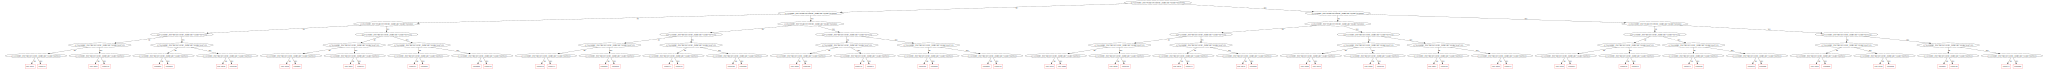

In [12]:
tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
tree.save("Outputs/"+MODEL_FILENAME+"_CATB/TB_Tree"+".svg")
tree

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [13]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()))
end_time("TB_CATB")
end_time("IB_CATB")

#Saving Model as file
ib_catb.save_model("Outputs/"+MODEL_FILENAME+"_IB_CATB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.050737


Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.5617221	test: 0.5612706	best: 0.5612706 (0)	total: 117ms	remaining: 1m 57s
1:	total: 229ms	remaining: 1m 54s
2:	total: 333ms	remaining: 1m 50s
3:	total: 436ms	remaining: 1m 48s
4:	total: 536ms	remaining: 1m 46s
5:	learn: 0.1944060	test: 0.1931298	best: 0.1931298 (5)	total: 644ms	remaining: 1m 46s
6:	total: 739ms	remaining: 1m 44s
7:	total: 840ms	remaining: 1m 44s
8:	total: 937ms	remaining: 1m 43s
9:	total: 1.04s	remaining: 1m 42s
10:	learn: 0.0896650	test: 0.0893880	best: 0.0893880 (10)	total: 1.15s	remaining: 1m 43s
11:	total: 1.25s	remaining: 1m 43s
12:	total: 1.35s	remaining: 1m 42s
13:	total: 1.45s	remaining: 1m 42s
14:	total: 1.55s	remaining: 1m 41s
15:	learn: 0.0535255	test: 0.0536332	best: 0.0536332 (15)	total: 1.66s	remaining: 1m 42s
16:	total: 1.77s	remaining: 1m 42s
17:	total: 1.87s	remaining: 1m 41s
18:	total: 1.97s	remaining: 1m 41s
19:	total: 2.07s	remaining: 1m 41s
20:	learn: 0.0395110	test: 0.0400250	best: 0.0400250 (20)	total: 2.19s	remaining: 1m 42s
21:	tot

180:	learn: 0.0156343	test: 0.0204294	best: 0.0204294 (180)	total: 18.7s	remaining: 1m 24s
181:	total: 18.8s	remaining: 1m 24s
182:	total: 18.9s	remaining: 1m 24s
183:	total: 19s	remaining: 1m 24s
184:	total: 19.1s	remaining: 1m 24s
185:	learn: 0.0154216	test: 0.0203556	best: 0.0203556 (185)	total: 19.2s	remaining: 1m 24s
186:	total: 19.3s	remaining: 1m 24s
187:	total: 19.4s	remaining: 1m 23s
188:	total: 19.5s	remaining: 1m 23s
189:	total: 19.6s	remaining: 1m 23s
190:	learn: 0.0153126	test: 0.0203138	best: 0.0203138 (190)	total: 19.7s	remaining: 1m 23s
191:	total: 19.8s	remaining: 1m 23s
192:	total: 19.9s	remaining: 1m 23s
193:	total: 20s	remaining: 1m 23s
194:	total: 20.1s	remaining: 1m 23s
195:	learn: 0.0150865	test: 0.0201546	best: 0.0201546 (195)	total: 20.2s	remaining: 1m 22s
196:	total: 20.3s	remaining: 1m 22s
197:	total: 20.4s	remaining: 1m 22s
198:	total: 20.5s	remaining: 1m 22s
199:	total: 20.6s	remaining: 1m 22s
200:	learn: 0.0149890	test: 0.0201267	best: 0.0201267 (200)	tota

356:	total: 37.3s	remaining: 1m 7s
357:	total: 37.4s	remaining: 1m 7s
358:	total: 37.5s	remaining: 1m 6s
359:	total: 37.6s	remaining: 1m 6s
360:	learn: 0.0114850	test: 0.0188727	best: 0.0188727 (360)	total: 37.7s	remaining: 1m 6s
361:	total: 37.8s	remaining: 1m 6s
362:	total: 37.9s	remaining: 1m 6s
363:	total: 38s	remaining: 1m 6s
364:	total: 38.1s	remaining: 1m 6s
365:	learn: 0.0113845	test: 0.0188486	best: 0.0188486 (365)	total: 38.3s	remaining: 1m 6s
366:	total: 38.4s	remaining: 1m 6s
367:	total: 38.5s	remaining: 1m 6s
368:	total: 38.6s	remaining: 1m 5s
369:	total: 38.7s	remaining: 1m 5s
370:	learn: 0.0112712	test: 0.0187963	best: 0.0187963 (370)	total: 38.8s	remaining: 1m 5s
371:	total: 38.9s	remaining: 1m 5s
372:	total: 39s	remaining: 1m 5s
373:	total: 39.1s	remaining: 1m 5s
374:	total: 39.2s	remaining: 1m 5s
375:	learn: 0.0111688	test: 0.0187415	best: 0.0187415 (375)	total: 39.3s	remaining: 1m 5s
376:	total: 39.4s	remaining: 1m 5s
377:	total: 39.5s	remaining: 1m 5s
378:	total: 39

537:	total: 56.7s	remaining: 48.7s
538:	total: 56.9s	remaining: 48.6s
539:	total: 57s	remaining: 48.5s
540:	learn: 0.0088595	test: 0.0181205	best: 0.0181205 (540)	total: 57.1s	remaining: 48.4s
541:	total: 57.2s	remaining: 48.3s
542:	total: 57.3s	remaining: 48.2s
543:	total: 57.4s	remaining: 48.1s
544:	total: 57.6s	remaining: 48.1s
545:	learn: 0.0088014	test: 0.0180951	best: 0.0180951 (545)	total: 57.7s	remaining: 48s
546:	total: 57.8s	remaining: 47.9s
547:	total: 57.9s	remaining: 47.8s
548:	total: 58s	remaining: 47.7s
549:	total: 58.1s	remaining: 47.6s
550:	learn: 0.0087202	test: 0.0180598	best: 0.0180598 (550)	total: 58.2s	remaining: 47.5s
551:	total: 58.4s	remaining: 47.4s
552:	total: 58.5s	remaining: 47.3s
553:	total: 58.6s	remaining: 47.2s
554:	total: 58.7s	remaining: 47.1s
555:	learn: 0.0086719	test: 0.0180378	best: 0.0180378 (555)	total: 58.8s	remaining: 47s
556:	total: 58.9s	remaining: 46.9s
557:	total: 59s	remaining: 46.8s
558:	total: 59.1s	remaining: 46.7s
559:	total: 59.3s	re

717:	total: 1m 17s	remaining: 30.3s
718:	total: 1m 17s	remaining: 30.2s
719:	total: 1m 17s	remaining: 30.1s
720:	learn: 0.0069651	test: 0.0178905	best: 0.0178770 (710)	total: 1m 17s	remaining: 30s
721:	total: 1m 17s	remaining: 29.9s
722:	total: 1m 17s	remaining: 29.8s
723:	total: 1m 17s	remaining: 29.7s
724:	total: 1m 17s	remaining: 29.5s
725:	learn: 0.0069353	test: 0.0178745	best: 0.0178745 (725)	total: 1m 18s	remaining: 29.4s
726:	total: 1m 18s	remaining: 29.3s
727:	total: 1m 18s	remaining: 29.2s
728:	total: 1m 18s	remaining: 29.1s
729:	total: 1m 18s	remaining: 29s
730:	learn: 0.0068971	test: 0.0178824	best: 0.0178745 (725)	total: 1m 18s	remaining: 28.9s
731:	total: 1m 18s	remaining: 28.8s
732:	total: 1m 18s	remaining: 28.7s
733:	total: 1m 18s	remaining: 28.6s
734:	total: 1m 18s	remaining: 28.5s
735:	learn: 0.0068657	test: 0.0178605	best: 0.0178605 (735)	total: 1m 19s	remaining: 28.4s
736:	total: 1m 19s	remaining: 28.2s
737:	total: 1m 19s	remaining: 28.1s
738:	total: 1m 19s	remaining

895:	learn: 0.0058454	test: 0.0179481	best: 0.0178403 (750)	total: 1m 35s	remaining: 11.1s
896:	total: 1m 35s	remaining: 11s
897:	total: 1m 35s	remaining: 10.9s
898:	total: 1m 35s	remaining: 10.8s
899:	total: 1m 36s	remaining: 10.7s
900:	learn: 0.0058201	test: 0.0179479	best: 0.0178403 (750)	total: 1m 36s	remaining: 10.6s
901:	total: 1m 36s	remaining: 10.5s
902:	total: 1m 36s	remaining: 10.4s
903:	total: 1m 36s	remaining: 10.2s
904:	total: 1m 36s	remaining: 10.1s
905:	learn: 0.0057867	test: 0.0179281	best: 0.0178403 (750)	total: 1m 36s	remaining: 10s
906:	total: 1m 36s	remaining: 9.93s
907:	total: 1m 36s	remaining: 9.82s
908:	total: 1m 37s	remaining: 9.71s
909:	total: 1m 37s	remaining: 9.6s
910:	learn: 0.0057479	test: 0.0179559	best: 0.0178403 (750)	total: 1m 37s	remaining: 9.5s
911:	total: 1m 37s	remaining: 9.39s
912:	total: 1m 37s	remaining: 9.28s
913:	total: 1m 37s	remaining: 9.18s
914:	total: 1m 37s	remaining: 9.07s
915:	learn: 0.0057280	test: 0.0179803	best: 0.0178403 (750)	total:

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

In [14]:
print(classification_report(y_ib_validate, ib_catb.predict(X_ib_validate),digits=4))

              precision    recall  f1-score   support

           0     0.9986    0.9915    0.9950     11640
           1     0.9914    0.9986    0.9950     11468

    accuracy                         0.9950     23108
   macro avg     0.9950    0.9950    0.9950     23108
weighted avg     0.9950    0.9950    0.9950     23108



### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

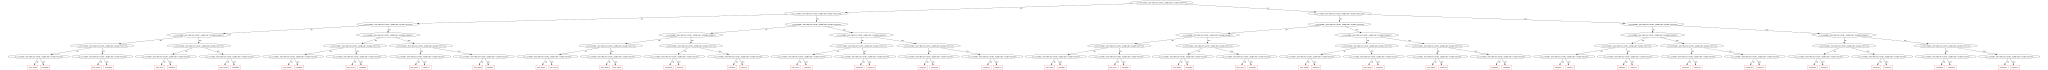

In [15]:
tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
tree.save("Outputs/"+MODEL_FILENAME+"_CATB/IB_Tree"+".svg")
tree

In [16]:
logging("\n")